In [345]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt  # 导入Matplotlib库

In [346]:
# 计算成对距离的函数
from sklearn.metrics import pairwise_distances

# 计算每个数据点的平均邻域半径
def compute_average_radius(X):
    n_samples = X.shape[0]
    avg_radii = np.zeros(n_samples)
    
    for i in range(n_samples):
        distances = pairwise_distances(X[i].reshape(1, -1), X).flatten()
        avg_radius = np.mean(distances)
        avg_radii[i] = avg_radius
    
    return avg_radii


In [347]:
# 构建 epsilon 邻域的邻接图
def epsilon_neighborhood(X, epsilon):
    n_samples = X.shape[0]
    adjacency_matrix = np.zeros((n_samples, n_samples), dtype=int)
    
    for i in range(n_samples):
        distances = pairwise_distances(X[i].reshape(1, -1), X).flatten()
        neighbors = np.where(distances <= epsilon)[0]
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1
    
    return adjacency_matrix


In [348]:
# 构建基于 epsilon 邻域的权重矩阵
def construct_weight_matrix_epsilon(X, avg_radii, t):
    n_samples = len(X)
    weight_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        adjacency_matrix = epsilon_neighborhood(X, avg_radii[i])
        
        for j in range(n_samples):
            if adjacency_matrix[i, j] == 1:
                distance = np.linalg.norm(X[i] - X[j])
                weight_matrix[i, j] = np.exp(-distance ** 2 / t)
    
    return weight_matrix

In [349]:
# 进行特征映射
def eigen_mapping(L, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(L)
    np.savetxt('eigenvalues.csv', eigenvalues, delimiter=',')
    np.savetxt('eigenvectors.csv', eigenvectors, delimiter=',')
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    return selected_eigenvectors

In [350]:
# LPP 算法
def LPP_epsilon(X, n_components, t):
    # Step 1: 计算每个数据点的平均邻域半径
    avg_radii = compute_average_radius(X)
    
    # Step 2: 构建基于 epsilon 邻域的权重矩阵
    Weight_matrix = construct_weight_matrix_epsilon(X, avg_radii, t)

    # Step 3: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix

    # Step 4: 进行特征映射
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    sorted_indices = np.argsort(eigenvalues)
    selected_indices = sorted_indices[1:n_components + 1]
    selected_eigenvectors = eigenvectors[:, selected_indices]
    
    return selected_eigenvectors

(-6.360909164736286,
 9.477276932362324,
 0.0010920470810349414,
 19.97190292286955,
 -4.814017829939432,
 7.916709742100855)

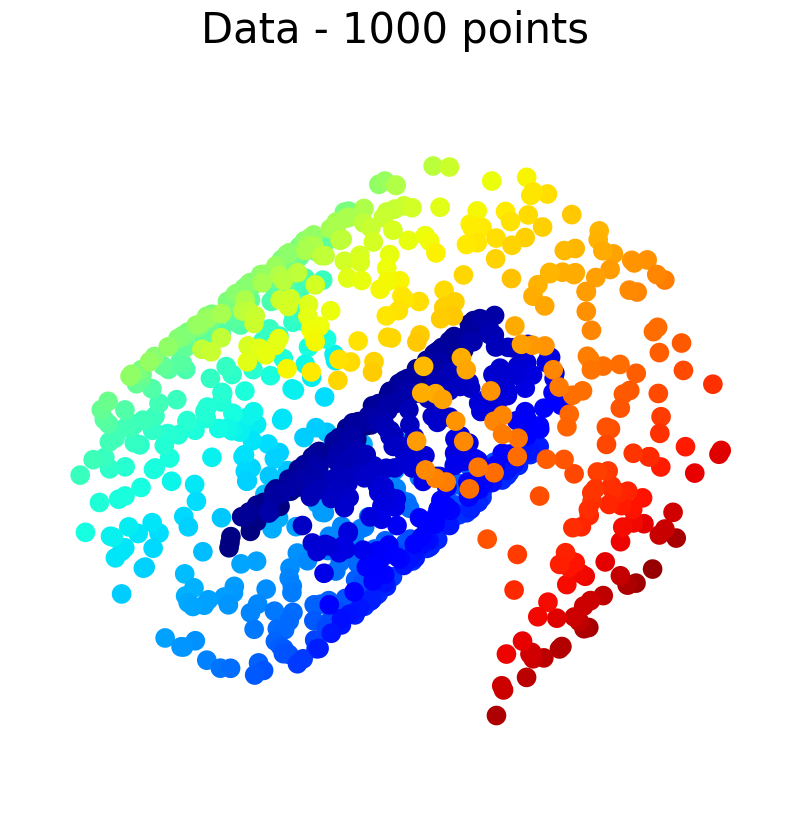

In [351]:
# 示例数据
Data = np.load('D:/OneDrive - email.szu.edu.cn/Manifold Learning/swiss roll-1000.npy')

np.savetxt('Data.csv', Data, delimiter=',')

# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")

In [352]:
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)

np.savetxt('Data_T.csv', Data_T, delimiter=',')

# 设置降维参数
n_neighbors = 150
n_components = 2
method = 'epsilon' # 方法选择knn或者epsilon
epsilon = 7.5
t = 200 # 设置热核参数

# 执行LPP算法
lpp_embeddings = LPP_epsilon(Data_T, n_components, t)

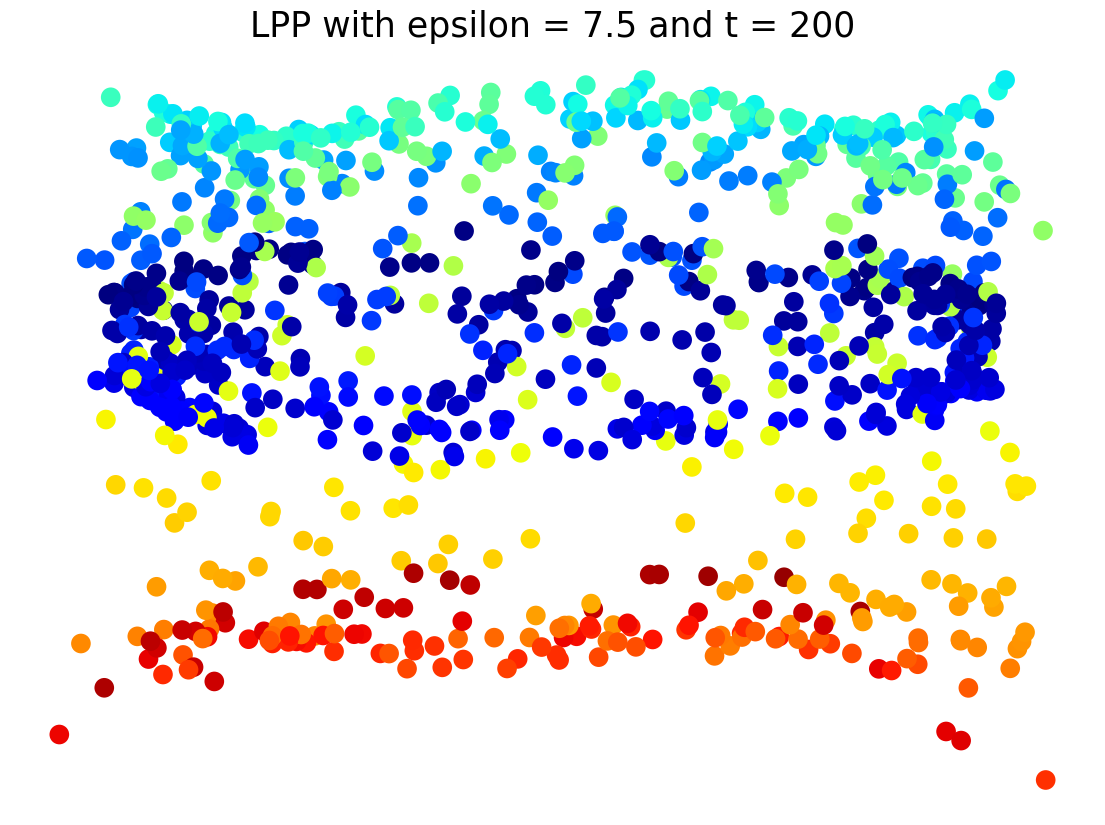

In [353]:
# 绘制及保存投影图
import os
plt.figure(figsize=(14,10))
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
if method == 'epsilon':
    plt.title('LPP with epsilon = ' + str(epsilon) + ' and t = ' + str(t), size=25)
    file_name = 'LPP_epsilon_' + str(epsilon) + '_t_' + str(t) + '.png'
file_path = os.path.join('.', 'output', file_name)
plt.savefig(file_path)
plt.axis("off")
plt.show()

In [354]:
'''
# 设置 epsilon 和 t 的范围和步长。epsilon_range从6.5到8，每次变化0.01，t_range从15到20，每次变化0.1
epsilon_range = np.arange(6.5, 8, 0.01)
t_range = np.arange(15, 20, 0.1)

# 循环遍历不同的 epsilon 和 t
for epsilon in epsilon_range:
    for t in t_range:
        # 执行 LPP 算法
        lpp_embeddings = LPP(Data_T, n_neighbors=n_neighbors, n_components=n_components, method=method, epsilon=epsilon, t=t)
        # 绘制投影图
        plt.figure(figsize=(14,10))
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
        plt.title('LPP with epsilon = ' + str(epsilon) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_' + str(epsilon) + '_t_' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.savefig(file_path)
        plt.close()
'''

"\n# 设置 epsilon 和 t 的范围和步长。epsilon_range从6.5到8，每次变化0.01，t_range从15到20，每次变化0.1\nepsilon_range = np.arange(6.5, 8, 0.01)\nt_range = np.arange(15, 20, 0.1)\n\n# 循环遍历不同的 epsilon 和 t\nfor epsilon in epsilon_range:\n    for t in t_range:\n        # 执行 LPP 算法\n        lpp_embeddings = LPP(Data_T, n_neighbors=n_neighbors, n_components=n_components, method=method, epsilon=epsilon, t=t)\n        # 绘制投影图\n        plt.figure(figsize=(14,10))\n        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)\n        plt.title('LPP with epsilon = ' + str(epsilon) + ' and t = ' + str(t), size=25)\n        file_name = 'LPP_epsilon_' + str(epsilon) + '_t_' + str(t) + '.png'\n        file_path = os.path.join('.', 'output', file_name)\n        plt.savefig(file_path)\n        plt.close()\n"

In [355]:
import pandas as pd
if method == 'epsilon':
    csvs = ['Data.csv', 'Data_T.csv', 'e-adjacency_matrix.csv', 'e-Weight_matrix.csv','Degree_matrix.csv', 'Laplacian_matrix.csv','eigenvalues.csv', 'eigenvectors.csv', 'selected_eigenvectors.csv']
    for csv in csvs:
        df = pd.read_csv(csv, header=None)
        dimension = df.shape
        print(f"Dimension of {csv}: {dimension}")

Dimension of Data.csv: (3, 1000)
Dimension of Data_T.csv: (1000, 3)
Dimension of e-adjacency_matrix.csv: (1000, 1000)
Dimension of e-Weight_matrix.csv: (1000, 1000)
Dimension of Degree_matrix.csv: (1000, 1000)
Dimension of Laplacian_matrix.csv: (1000, 1000)
Dimension of eigenvalues.csv: (1000, 1)
Dimension of eigenvectors.csv: (1000, 1000)
Dimension of selected_eigenvectors.csv: (1000, 2)


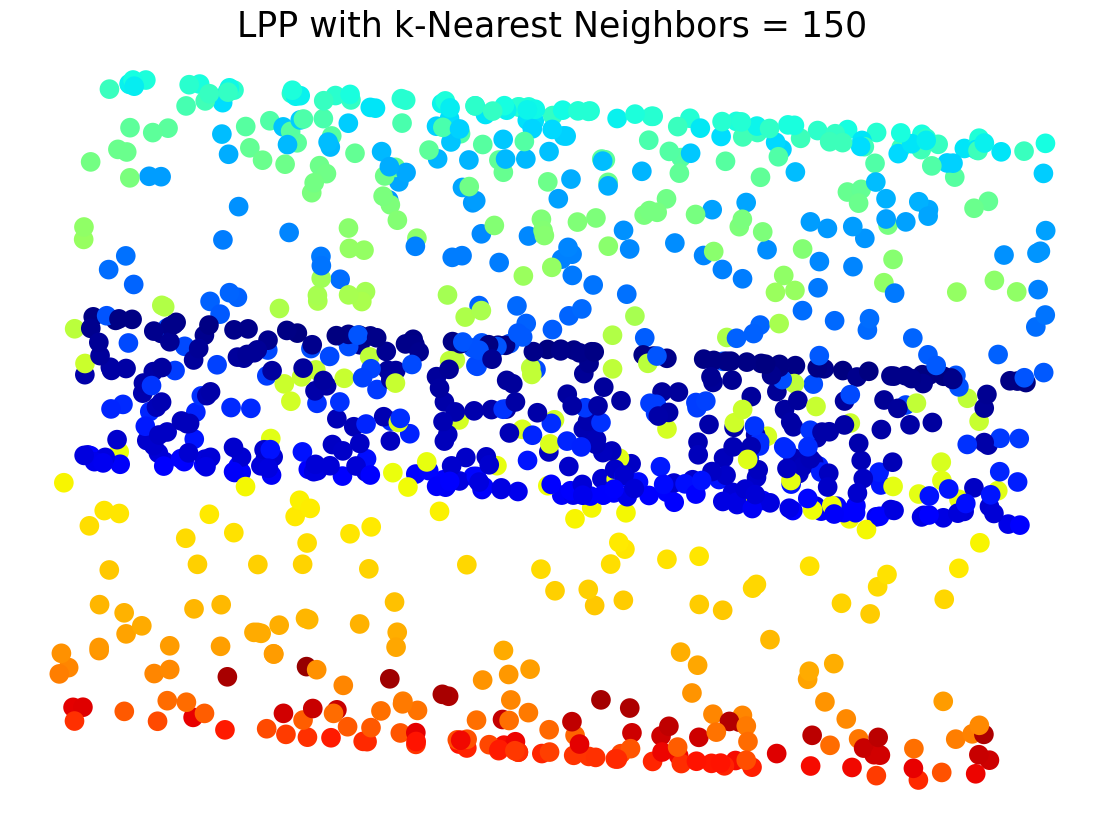

In [356]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components= n_components)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)

# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=25)
plt.axis("off")
plt.show()